# importing the MNIST dataset from sklearn itself


In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-pastel")
sns.set_theme(color_codes=True)

In [2]:
mnist = fetch_openml('mnist_784', version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
x, y = mnist["data"], mnist["target"]

In [5]:
y = y.astype("int")

In [6]:
y

array([5, 0, 4, ..., 4, 5, 6])

# plotting an image

we'll need to resize it to 28x28 array, and plot using matplotlib

(-0.5, 27.5, 27.5, -0.5)

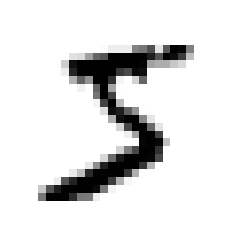

In [7]:
some_digit = x[0]
some_digit_img = some_digit.reshape(28,28)

plt.imshow(some_digit_img, cmap='binary')
plt.axis("off")

In [8]:
y[0]

5

# splitting the dataset 

the dataset is already split, we just need to assign the variables to it

split already in 60k and 10k ratio 


In [9]:
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

# training a binary classifier

lets say a classifier just to classify whether an image is of digit 5 or not

2 classes -> 5 and not-5


In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [11]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [12]:
# now we can make a model of stochastic gradient descent, for our binary classification problem 
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_5)


SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

# performance measure
this is an important and trickier part when dealing with classifications

## writing manual cross validation test code

this way we get more control over the cv test, than what's provided by cross_val_score / cross_val_predict

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_fold = x_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    
    print(n_correct/len(y_pred))

/Users/pushpakruhil/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train_5, cv=3)

array([0.95035, 0.96035, 0.9604 ])

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

# confusion matrix

for this, we 1st need predictions, which can be calculated using cross_val_predict

after that, we can import confusion matrix and form our matrix using, target array and prediction array

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

confusion_matrix(y_train_5, y_pred)

array([[53892,   687],
       [ 1891,  3530]])

# precision, recall and F1 score

precision = TP/(TP+FP)

recall = TP/(TP+FN)

f1_score = harmonic mean of both = 2/( (1/precision) + (1/recall) )

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(precision_score(y_train_5, y_pred))
print(recall_score(y_train_5, y_pred))
print(f1_score(y_train_5, y_pred))

0.8370879772350012
0.6511713705958311
0.7325171197343846


# precision recall trade-off

is you increase precision, recall drops and vice versa

In [19]:
y_score = sgd_clf.decision_function([some_digit])

In [20]:
threshold = 0
y_some_digit_pred = (y_score > threshold)
print(y_some_digit_pred)

[ True]


In [21]:
threshold = 8000
y_some_digit_pred = (y_score > threshold)
print(y_some_digit_pred)

[False]


In [22]:
#step 1

y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3,
                            method = "decision_function")


In [23]:
#step 2

from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train_5, y_scores)

Text(0.5, 0, 'Threshold')

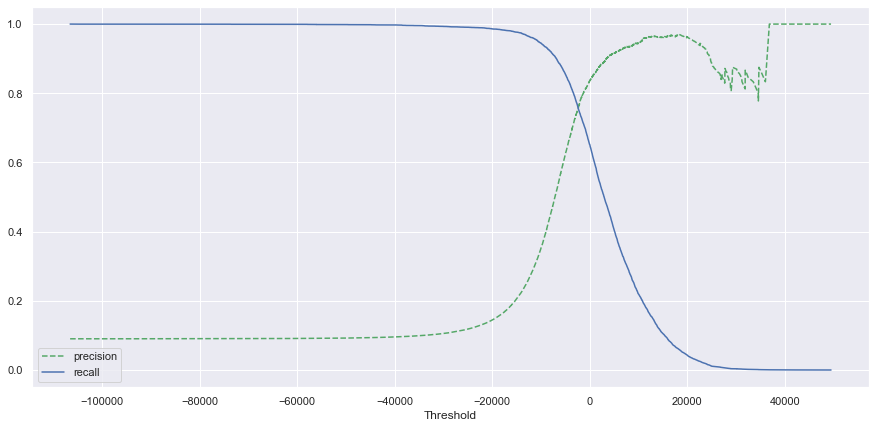

In [24]:
#step 3
fig = plt.gcf()
fig.set_size_inches(15,7)
plt.plot(threshold, precision[:-1], "g--", label="precision")
plt.plot(threshold, recall[:-1], "b-", label="recall")
plt.legend()
plt.xlabel("Threshold")

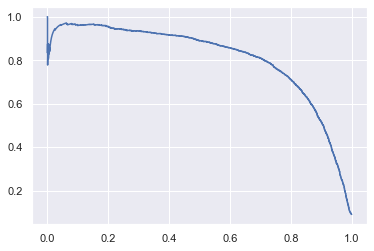

In [25]:
plt.plot(recall[:-1], precision[:-1])
#plt.plot(recall, precision)


In [26]:
threshold_90_pred = threshold[np.argmax(precision>=0.90)]
y_train_pred_90 = (y_scores >= threshold_90_pred)

In [27]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [28]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# ROC curve

receiver operating characteristic curve

In [29]:
from sklearn.metrics import roc_curve
TPR, FPR, threshold = roc_curve(y_train_5, y_scores)

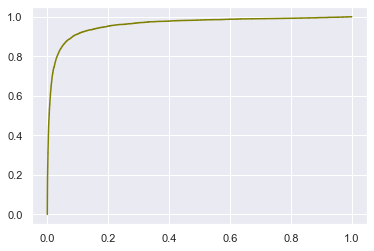

In [30]:
plt.plot(TPR, FPR, color="olive")

In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [32]:
#trying roc curve for random forest classifier
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)

#this doesn't have a decision_function, but a predict_proba() which gives us the probability

y_prob_rf = cross_val_predict(rf_clf, x_train, y_train_5, cv=3,
                               method="predict_proba")


In [33]:
y_scores_rf = y_prob_rf[:, 1] #all rows of 1st class, are the scores
TPR_rf, FPR_rf, threshold_rf = roc_curve(y_train_5, y_scores_rf)

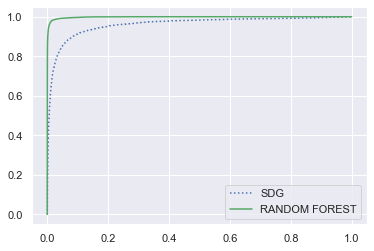

In [34]:
plt.plot(TPR, FPR, "b:", label="SDG")
plt.plot(TPR_rf, FPR_rf, "g-", label="RANDOM FOREST")
plt.legend(loc="lower right")


#more area under curve, better than sgd

# multiclass classifier

2 strategies, OvO and OvR

sklearn chooses automatically these strategies according to the model we call, under the hood.

some explicitly support multiclass classification and dont need a strategy chosen under the hood

In [35]:
from sklearn.svm import SVC
svm_clf = SVC()

In [36]:
#svm_clf.fit(x_train, y_train)

#will train 45 binary classifiers in accordance to OvO classifier

In [37]:
#svm_clf.predict([some_digit])


In [38]:
#some_digit_scores = svm_clf.decision_function([some_digit])

In [39]:
#some_digit_scores

## manually choosing OvO or OvR classifiers

In [40]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier

#   ---this will take endless amt of time to execute---

# ovr_clf = OneVsRestClassifier(SVC())
# ovr_clf.fit(x_train, y_train)

In [41]:
# ovr_clf.predict([some_digit])

training sgdclassifier and rf classifiers is just as easy, but under the hood, no OvR or OvO takes places, they by default support multiclass classification


In [42]:
sgd_clf.fit(x_train, y_train)

SGDClassifier(random_state=42)

In [43]:
sgd_clf.predict([some_digit])

array([3])

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

In [ ]:
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=2)

# error analysis

In [86]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)
conf_mat = confusion_matrix(y_train, y_train_pred)


In [87]:
conf_mat = confusion_matrix(y_train, y_train_pred)
conf_mat

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

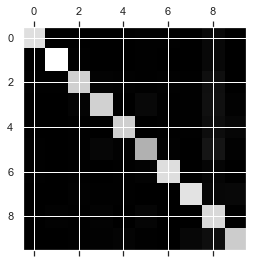

In [88]:
plt.matshow(conf_mat, cmap=plt.cm.gray)


In [89]:
row_sum = conf_mat.sum(axis=1, keepdims=True)

In [90]:
norm_conf_mat = conf_mat/row_sum

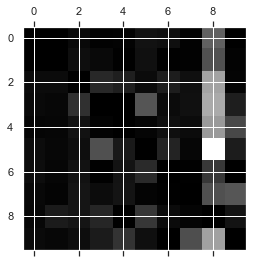

In [91]:
np.fill_diagonal(norm_conf_mat, 0)
plt.matshow(norm_conf_mat, cmap=plt.cm.gray)

#white boxes are wrong classifications, so use tricks to correct them like adding more data for correct classifcation, etc